In [1]:
import pandas as pd
import numpy as np
import matminer as mm
import sklearn as sl
from mendeleev import element
import sys
import matplotlib.pyplot as plt
import matminer

In [2]:
from matminer.datasets.convenience_loaders import load_elastic_tensor
df = load_elastic_tensor()


unwanted_columns = ["volume", "nsites", "compliance_tensor", "elastic_tensor", 
                   "elastic_tensor_original", "K_Voigt", "G_Voigt", "K_Reuss", "G_Reuss"]
df = df.drop(unwanted_columns, axis=1)

df.shape

(1181, 8)

In [3]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

#df = StrToComposition().featurize_dataframe(df, "formula")
#ep_feat = ElementProperty.from_preset(preset_name="magpie")
#df = ep_feat.featurize_dataframe(df, col_id="composition")  # input the "composition" column to the featurizer

#df.shape

In [4]:
# To load the Data
imps_df = pd.read_csv('d_block_magnetic_data_modified.csv')

import time as time 
def val_shell_e_conf(elements, imp=0):
    from tqdm import tqdm
    from mendeleev import element as el
    
    sub_orbitals = {'s':[], 'p':[], 'd':[], 'f':[]}
    spdf = sub_orbitals.keys()
    
    els = {}
    for x in list(range(20,50)):
        els[x] = el(x) ## The is now on RAM.
    
    for element in iter(elements):
        
        sub_orbitals['s'].append(0)
        sub_orbitals['p'].append(0)
        sub_orbitals['d'].append(0)
        sub_orbitals['f'].append(0)
        
        econf = els[element].econf.split(' ')[1:]
        #econf = el(element).econf.split(' ')[1:]
        
       # print(econf)
        for sub_orb in econf:
            try:
                sym, val = list(sub_orb)[1], list(sub_orb)[2]
            except IndexError:
                sym, val = list(sub_orb)[1] , 1
            sub_orbitals[sym][-1] = int(val)

    sub_orbitals_ = dict()
    sub_orbitals_['s0'+ str(imp)] = sub_orbitals['s']
    sub_orbitals_['p0'+ str(imp)] = sub_orbitals['p']
    sub_orbitals_['d0'+ str(imp)] = sub_orbitals['d']
    sub_orbitals_['f0'+ str(imp)] = sub_orbitals['f']
    return sub_orbitals_

def get_en_etc(elements):
    
    from mendeleev import element as el
    from tqdm import tqdm
    
    group1 = []
    period1 = []
    ea1 = []
    en1 = []
    group2 = []
    period2 = []
    ea2 = []
    en2 = []
    
    els = {}
    for Zimp in tqdm(list(range(21,31)) + list(range(39,49))):
        els[Zimp] = el(Zimp)
    
    for imp1 in tqdm(iter(elements['imp0'])):
        ee = els[imp1]
        group1.append(ee.group_id)
        period1.append(ee.period)
        ea1.append(ee.electron_affinity)
        en1.append(ee.en_allen)
    for imp2 in tqdm(iter(elements['imp1'])):
        ee = els[imp2]
        group2.append(ee.group_id)
        period2.append(ee.period)
        ea2.append(ee.electron_affinity)
        en2.append(ee.en_allen)
        

    additional_columns = dict(group1=group1, period1=period1, en1=en1, # , ea1=ea1
                              group2=group2, period2=period2, en2=en2, # , ea2=ea2
                             )

    return additional_columns

### To add extra features from which we obtained
# the file : d_block_magnetic_data_modified_extend.csv

#dic0 = val_shell_e_conf(imps_df['imp0'])
#dic1 = val_shell_e_conf(imps_df['imp1'], imp=1)
#spdf0 = pd.DataFrame(dic0)
#spdf1 = pd.DataFrame(dic1)
#add_cols = pd.DataFrame(get_en_etc(imps_df))
#imps_df_extended = imps_df
#imps_df_extended = pd.merge(imps_df_extended, spdf0, left_index=True, right_index=True)
#imps_df_extended = pd.merge(imps_df_extended, spdf1, left_index=True, right_index=True)
#imps_df_extended = pd.merge(imps_df_extended, add_cols, left_index=True, right_index=True)
#imps_df_extended.to_csv(path_or_buf='./d_block_magnetic_data_modified_extend.csv', index_label=False)
##df_ml_ext = pd.read_csv('./d_block_magentic_data_extend.csv')
df_ml_ext = pd.read_csv('./d_block_magnetic_data_modified_extend.csv')


In [5]:
# Further extention of the df_ml_ext
def hund_rule(electrons, half_elec):
    if electrons<= half_elec:
        return electrons
    else:
        return (2*half_elec - electrons)
    
df_ml_ext['del_imp'] = df_ml_ext['imp1']-df_ml_ext['imp0']
df_ml_ext['del_d'] = df_ml_ext['d01']-df_ml_ext['d00']
df_ml_ext['del_s'] = df_ml_ext['s01']-df_ml_ext['s00']
df_ml_ext['del_en'] = df_ml_ext['en1']-df_ml_ext['en2']
df_ml_ext['d00_odd_spin'] = [hund_rule(elec, 5) for elec in df_ml_ext['d00']]
df_ml_ext['d01_odd_spin'] = [hund_rule(elec, 5) for elec in df_ml_ext['d01']] 
df_ml_ext['s00_odd_spin'] = [hund_rule(elec, 1) for elec in df_ml_ext['s00']] 
df_ml_ext['s01_odd_spin'] = [hund_rule(elec, 1) for elec in df_ml_ext['s01']]
df_ml_ext['tot_odd_spin_00'] = df_ml_ext['s00_odd_spin'] + df_ml_ext['d00_odd_spin']
df_ml_ext['tot_odd01_spin_00'] = df_ml_ext['s01_odd_spin'] + df_ml_ext['d01_odd_spin']
#filtering Jij values
df_ml_ext['J'] = round(df_ml_ext['J'], 10)


In [40]:
df_ml = df_ml_ext.drop(['calc_imps', 'J_data_uuid', 'offset0', 'offset1', 'ilayer0', 'ilayer1',#'tot_odd_spin_00', 'tot_odd_spin_00',
                       'i', 'j', 'tot_mom', 'D', 'Dx', 'Dy', 'Dz', 'Z_i', 'Z_j'], axis = 1)
df_ml.drop_duplicates()

,imp0,imp1,J,rx,ry,rz,r,mom1,mom2,s00,...,del_imp,del_d,del_s,del_en,d00_odd_spin,d01_odd_spin,s00_odd_spin,s01_odd_spin,tot_odd_spin_00,tot_odd01_spin_00
0,21,22,0.012427,-0.418515,0.0,0.0,0.418515,1.856702e-06,8.152756e-01,2,...,1,1,0,-1.128,1,2,0,0,1,2
1,21,39,-0.000000,-0.418515,0.0,0.0,0.418515,-4.173850e-11,-3.308398e-11,2,...,18,0,0,0.411,1,1,0,0,1,1
2,21,21,-0.000000,-0.418515,0.0,0.0,0.418515,-4.285949e-11,-4.675482e-11,2,...,0,0,0,0.000,1,1,0,0,1,1
3,25,21,0.082379,-0.418515,0.0,0.0,0.418515,4.409489e+00,1.069743e-02,2,...,-4,-4,0,3.298,5,1,0,0,5,1
4,24,21,0.039786,-0.418515,0.0,0.0,0.418515,3.815394e+00,4.514470e-03,1,...,-3,-4,1,2.728,5,1,1,0,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,24,41,-0.014761,-1.255545,0.0,0.0,1.255545,3.801801e+00,1.167183e+00,1,...,17,-1,0,1.430,5,4,1,1,6,5
1726,25,41,0.150288,-1.255545,0.0,0.0,1.255545,4.412639e+00,1.163480e+00,2,...,16,-1,-1,2.000,5,4,0,1,5,5
1727,42,41,0.338216,-1.255545,0.0,0.0,1.255545,2.574306e+00,1.171191e+00,1,...,-1,-1,0,0.370,5,4,1,1,6,5
1728,41,41,0.159493,-1.255545,0.0,0.0,1.255545,1.174797e+00,1.174470e+00,1,...,0,0,0,0.000,4,4,1,1,5,5


In [42]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model

crossvalidation = KFold(n_splits=5, shuffle= True, random_state=1)

#scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', 
#                        cv=crossvalidation, n_jobs=1)
#rmse_scores = [np.sqrt(abs(s)) for s in scores]
#r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=crossvalidation, n_jobs=-1)

#print('Cross-validation results:')
#print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
#print('Folds: %i, mean RMSE: %.5f' % (len(scores), np.mean(np.abs(rmse_scores))))
#

In [43]:
# Try different mechine learning model
y = df_ml['J'].values
X = df_ml.drop(['J', 'f00', 'f01', 'p00', 'p01'], axis=1)
# X = df_ml.drop(['J', 'imp0', 'imp1', 'f00', 'f01', 'p00', 'p01', 'group1', 'group2', 'period1', 'period2'], axis=1)
# X = df_ml.drop(['J', 'imp0', 'imp1', 'f00', 'f01', 'p00', 'p01', 'group1', 'group2', 'period1', 'period2', 'en1', 'en2'], axis=1)
# X = df_ml.drop(['J', 'imp0', 'imp1', 'f00', 'f01', 'p00', 'p01', 'group1', 'group2', 'period1', 'period2', 'en1', 'en2', 's00', 's01', 'd00', 'd01'], axis=1)
# X = df_ml.drop(['J', 'rx', 'ry', 'rz', 'mom1', 'mom2', 'imp0', 'imp1', 'f00', 'f01', 'p00', 'p01', 'en1', 'en2', 's00', 's01', 'd00', 'd01'], axis=1)
# X = df_ml.drop(['J', 'rx', 'ry', 'rz', 'mom1', 'mom2', 'group1', 'group2', 'period1', 'period2', 'f00', 'f01', 'p00', 'p01', 'en1', 'en2', 's00', 's01', 'd00', 'd01'], axis=1)

# , 'd00_odd_spin', 'd01_odd_spin', 's00_odd_spin', 's01_odd_spin','tot_odd_spin_00', 'tot_odd01_spin_00', 
X2 = df_ml.drop(['J', 'f00', 'f01', 'p00', 'p01', 'del_imp', 'mom1', 'mom2',
       'del_d', 'del_s', 'rx', 'ry', 'rz', 'imp0', 'imp1',
        's00', 's01', 'd00', 'd01'], axis=1)

#To try a linear regression model using scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression(fit_intercept=True)
weight = np.ones((len(y)))*10
lr.fit(X,y)

#lr_fit
print('R2 : '+ str(round(lr.score(X,y), 3)))
print('RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X))))

R2 : 0.085
RMSE : 2.583


In [44]:
X.columns

Index(['imp0', 'imp1', 'rx', 'ry', 'rz', 'r', 'mom1', 'mom2', 's00', 'd00',
       's01', 'd01', 'group1', 'period1', 'en1', 'group2', 'period2', 'en2',
       'del_imp', 'del_d', 'del_s', 'del_en', 'd00_odd_spin', 'd01_odd_spin',
       's00_odd_spin', 's01_odd_spin', 'tot_odd_spin_00', 'tot_odd01_spin_00'],
      dtype='object')

In [45]:
from sklearn.model_selection import train_test_split
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X, y, test_size=0.2)
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y, test_size=0.2)

## Data To run
Xtrain, Xtest, ytrain, ytest = Xtrain2, Xtest2, ytrain2, ytest2

In [62]:
rid_reg = linear_model.Ridge(alpha=1000, )
rid_reg.fit(Xtrain, ytrain)
print('Ridge Ression R2 : '+ str(round(rid_reg.score(Xtest,ytest), 3)))
print('Ridge Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, y_pred=rid_reg.predict(Xtest))))

SGD_reg = linear_model.SGDRegressor()
SGD_reg.fit(Xtrain,ytrain)
print('SGD Regression R2 : '+ str(round(SGD_reg.score(Xtest,ytest), 3)))
print('SGD Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, y_pred=SGD_reg.predict(Xtest))))

from sklearn import svm
#SVM_reg = svm.SVR(kernel= 'linear', C=10, gamma='auto', degree=4)
#SVM_reg.fit(X,y)
#print('SVM Regression R2 : '+ str(round(SVM_reg.score(X,y), 3)))
#print('SVM Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=SVM_reg.predict(X))))#

from sklearn.kernel_ridge import KernelRidge
KerRid_reg = KernelRidge(alpha=0.10, kernel='poly', degree=4)
KerRid_reg.fit(Xtrain,ytrain)
print('Ker Rid Regression R2 : '+ str(round(KerRid_reg.score(Xtest,ytest), 3)))
print('Ker Rid Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, y_pred=KerRid_reg.predict(Xtest))))

#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor
#k-NeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
KNeiReg = KNeighborsRegressor(n_neighbors=3)
KNeiReg.fit(Xtrain,ytrain)
print('K-Neighbor Regression R2 : '+ str(round(KNeiReg.score(Xtest,ytest), 3)))
print('K-Neighbor Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, y_pred=KNeiReg.predict(Xtest))))

#https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

#GaussianProcess Regressor
from sklearn.gaussian_process import GaussianProcessRegressor
GauProReg = GaussianProcessRegressor()
GauProReg.fit(Xtrain,ytrain)
print('Gaussian process Regression R2 : '+ str(round(GauProReg.score(Xtest,ytest), 3)))
print('Gaussian process Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, y_pred=GauProReg.predict(Xtest))))

#https://scikit-learn.org/stable/modules/tree.html#regression
from sklearn.tree import DecisionTreeRegressor
DecTreReg = DecisionTreeRegressor()
DecTreReg.fit(Xtrain,ytrain)
print('Decision Tree Regression from x data R2 Test: '+ str(round(DecTreReg.score(Xtest,ytest), 3)))
print('Decision Tree Regression from x data RMSE Test: %.3f' % np.sqrt(mean_squared_error(y_true=ytest, 
                                                                             y_pred=DecTreReg.predict(Xtest))))

DecTreReg2 = DecisionTreeRegressor()
DecTreReg2.fit(Xtrain,ytrain)
print('Decision Tree Regression from x data R2 Train: '+ str(round(DecTreReg2.score(Xtrain,ytrain), 3)))
print('Decision Tree Regression from x data RMSE Train: %.3f' % np.sqrt(mean_squared_error(y_true=ytrain, 
                                                                             y_pred=DecTreReg2.predict(Xtrain))))

from sklearn.ensemble import AdaBoostRegressor
AdaBooRegDecTre = AdaBoostRegressor(KerRid_reg,n_estimators=100)
AdaBooRegDecTre.fit(Xtrain, ytrain)
print('AdaBoost Regressor of Kernel Ridge from  x data R2 : '+ str(round(AdaBooRegDecTre.score(Xtest,ytest), 3)))
print('AdaBoost Regressor of Kernel Ridge from x data RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, 
                                                                             y_pred=AdaBooRegDecTre.predict(Xtest))))

AdaBooRegDecTre2 = AdaBoostRegressor(DecTreReg2,n_estimators=150)
AdaBooRegDecTre2.fit(Xtrain, ytrain)
print('AdaBoost Regressor of Decision Tree from x data R2 Test: '+ str(round(AdaBooRegDecTre2.score(Xtest,ytest), 3)))
print('AdaBoost Regressor of Decision Tree from x data RMSE Test: %.3f' % np.sqrt(mean_squared_error(y_true=ytest, 
                                                                             y_pred=AdaBooRegDecTre2.predict(Xtest))))
print('AdaBoost Regressor of Decision Tree from x data R2 Train : '+ str(round(AdaBooRegDecTre2.score(Xtrain,ytrain), 3)))
print('AdaBoost Regressor of Decision Tree from x data RMSE Train : %.3f' % np.sqrt(mean_squared_error(y_true=ytrain, 
                                                                             y_pred=AdaBooRegDecTre2.predict(Xtrain))))
#AdaBooReg2 = AdaBoostRegressor(KerRid_reg,n_estimators=150)
#AdaBooReg2.fit(Xtrain, ytrain)
#print('AdaBoost Regressor of KNeiReg from x data R2 : '+ str(round(AdaBooReg2.score(Xtest,ytest), 3)))
#print('AdaBoost Regressor of KNeiReg from x data RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, 
#                                                                             y_pred=AdaBooReg2.predict(Xtest))))


Ridge Ression R2 : 0.018
Ridge Regression RMSE : 2.696
SGD Regression R2 : 0.032
SGD Regression RMSE : 2.677
Ker Rid Regression R2 : 0.57
Ker Rid Regression RMSE : 1.785
K-Neighbor Regression R2 : 0.092
K-Neighbor Regression RMSE : 2.593
Gaussian process Regression R2 : -0.682
Gaussian process Regression RMSE : 3.529
Decision Tree Regression from x data R2 Test: 0.154
Decision Tree Regression from x data RMSE Test: 2.503
Decision Tree Regression from x data R2 Train: 1.0
Decision Tree Regression from x data RMSE Train: 0.000
AdaBoost Regressor of Kernel Ridge from  x data R2 : 0.011
AdaBoost Regressor of Kernel Ridge from x data RMSE : 2.706
AdaBoost Regressor of Decision Tree from x data R2 Test: 0.811
AdaBoost Regressor of Decision Tree from x data RMSE Test: 1.183
AdaBoost Regressor of Decision Tree from x data R2 Train : 0.999
AdaBoost Regressor of Decision Tree from x data RMSE Train : 0.077


AdaBoost Regressor of Decision Tree from x2 data R2 : 0.836
AdaBoost Regressor of Decision Tree from x2 data RMSE : 1.101


/tmp/ipykernel_2040267/2469123744.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontdict" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Adaboost_Tree_Reg.png', bbox_inches='tight', fontdict=font, dpi=300)


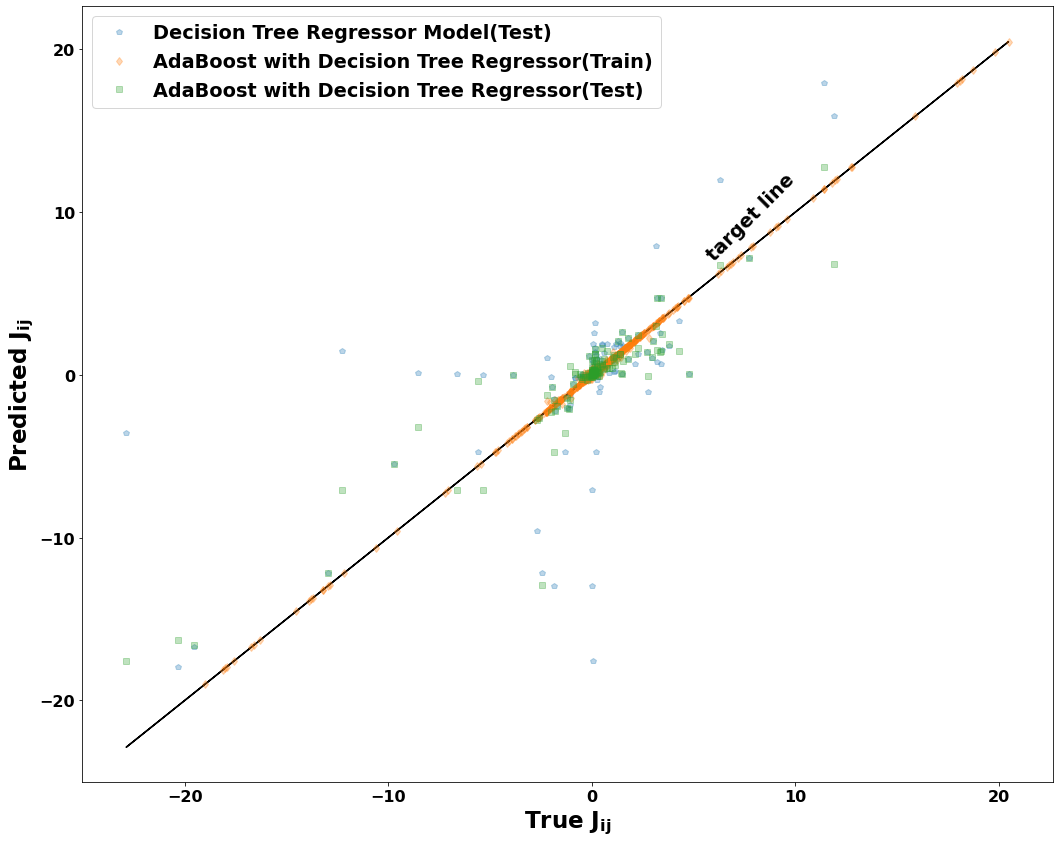

In [96]:
font = {'family':'Normal',
        'weight':'bold',
        'size':16
       }
plt.rc('font', **font)

plt.figure(figsize=(15,12))
from sklearn.kernel_ridge import KernelRidge

DecTreReg2 = DecisionTreeRegressor()
DecTreReg2.fit(Xtrain2,ytrain2)
DecTre2Pre = DecTreReg2.predict(Xtest2)

AdaBooRegDecTre2 = AdaBoostRegressor(DecTreReg2,n_estimators=100)
AdaBooRegDecTre2.fit(Xtrain2, ytrain2)

y_AdaBooRegDecTre2_tr_pre = AdaBooRegDecTre2.predict(Xtrain2)
y_AdaBooRegDecTre2_te_pre = AdaBooRegDecTre2.predict(Xtest2)
print('AdaBoost Regressor of Decision Tree from x2 data R2 : '+ str(round(AdaBooRegDecTre2.score(Xtest2,ytest2), 3)))
print('AdaBoost Regressor of Decision Tree from x2 data RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest2, 
                                                                             y_pred=AdaBooRegDecTre2.predict(Xtest2))))
plt.plot(y,y, 'black')
plt.text(s='target line', x=6, y=7, fontsize='large', rotation_mode='anchor', rotation=45, )
plt.plot(ytest2, DecTre2Pre, 'p', alpha= 0.3, label='Decision Tree Regressor Model(Test)')
plt.plot(ytrain2, y_AdaBooRegDecTre2_tr_pre, 'd', alpha=0.3, label='AdaBoost with Decision Tree Regressor(Train)')
plt.plot(ytest2, y_AdaBooRegDecTre2_te_pre, 's', alpha=0.3, label='AdaBoost with Decision Tree Regressor(Test)')

plt.legend(fontsize='large')
plt.ylabel('$\mathrm{Predicted\ J_{ij}}$', fontsize='x-large', weight= 'bold')
plt.xlabel('$\mathrm{True\ J_{ij}}$', fontsize='x-large', weight='bold')
plt.tight_layout()
plt.savefig('Adaboost_Tree_Reg.png', bbox_inches='tight', fontdict=font, dpi=300)

In [ ]:
np.sum(AdaBooRegDecTre2.feature_importances_)
xtick = list(Xtrain2.columns)
print(xtick)
xtick[1]= 'grp0'
xtick[2]= 'ped0'
xtick[3]= 'en0'
xtick[4]= 'grp1'
xtick[5]= 'ped1'
xtick[6]= 'en1'

xtick[8]= 'd0_OS'
xtick[9]= 'd1_OS'
xtick[10]= 's0_OS'
xtick[11]= 's1_OS'
xtick[12]= 'OS_0'
xtick[13]= 'OS_1'
font = {'family':'Normal',
        'size':14,
        'weight':'bold'
       }
plt.rc('font',**font)
plt.figure(figsize=(16,12))
plt.bar(np.arange(len(Xtrain2.columns))+.3, AdaBooRegDecTre2.feature_importances_,  width=0.4, tick_label=xtick, label='AdaBoost with Decision Tree Regressor')
plt.bar(np.arange(len(Xtrain2.columns)), DecTreReg2.feature_importances_,  width=0.4, tick_label=xtick, label='Decision Tree Regressor')
plt.legend(fontsize='large')
#plt.xticks(fontsize='large')
plt.ylabel('Relative Feature Importance',fontdict=font, fontsize='large')
plt.xlabel('Features',fontdict=font, fontsize='large')
plt.savefig('Adaboost_Tree_Reg_features_impor.png', bbox_inches='tight')

xtick

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

xtick = list(Xtrain2.columns)
print(xtick)
xtick[1]= 'grp0'
xtick[2]= 'perd0'
xtick[4]= 'grp1'
xtick[5]= 'perd1'

xtick[8]= 'd0_OS'
xtick[9]= 'd1_OS'
xtick[10]= 's0_OS'
xtick[11]= 's1_OS'
xtick[12]= 'OS_0'
xtick[13]= 'OS_1'

font = {'family':'Normal',
        'weight':'bold',
        'size':16
       }

plt.rc('font', **font)

#plt.figure(figsize=(10,8))
lr = LinearRegression(fit_intercept=True)
lr.fit(Xtrain2,ytrain2)

y_lr_tr_pre = lr.predict(Xtrain2)
y_lr_te_pre = lr.predict(Xtest2)

print('R2 : '+ str(round(lr.score(Xtest,ytest), 3)))
print('RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest, y_pred=y_lr_te_pre)))
plt.figure(figsize=(12,10))
plt.plot(y,y, 'black')
plt.text(s='target line', x=6, y=7, fontsize='large', rotation_mode='anchor', rotation=45, )
plt.plot(ytrain2, y_lr_tr_pre, 'p', alpha= 0.3, label='Linear Regressor Model(Train)')
plt.plot(ytest2, y_lr_te_pre, 's', alpha=0.3, label='Linear Regressor Model(Test)')

plt.legend(fontsize='large')
plt.ylabel('$\mathrm{Predicted\ J_{ij}}$', fontsize='x-large', weight= 'bold')
plt.xlabel('$\mathrm{True\ J_{ij}}$', fontsize='x-large', weight='bold')
plt.tight_layout()
plt.savefig('LinearRegressor_model_.png', bbox_inches='tight', dpi=300)

KerRid Regression R2 : 0.57
KerRid Regression RMSE : 1.785
['r', 'group1', 'period1', 'en1', 'group2', 'period2', 'en2', 'del_en', 'd00_odd_spin', 'd01_odd_spin', 's00_odd_spin', 's01_odd_spin', 'tot_odd_spin_00', 'tot_odd01_spin_00']


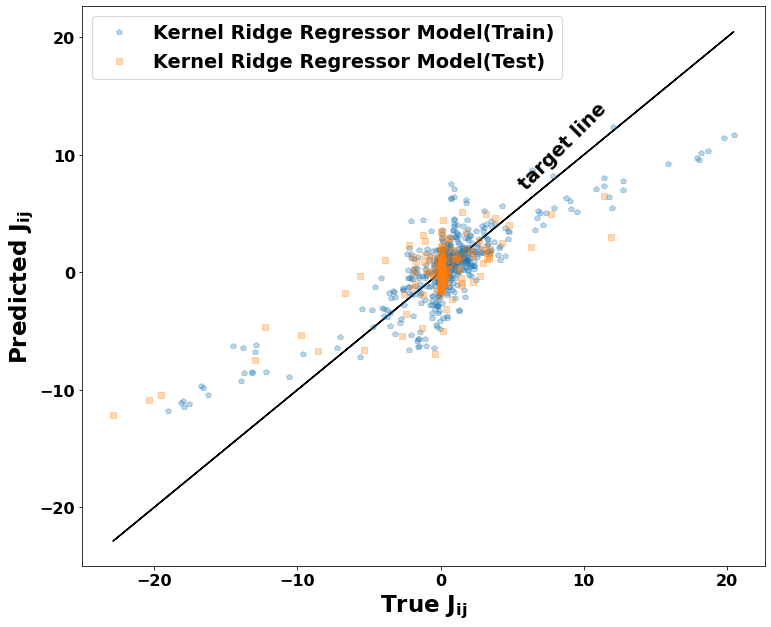

In [88]:
from sklearn.kernel_ridge import KernelRidge
KerRid_reg = KernelRidge(alpha=0.10, kernel='poly', degree=4)
KerRid_reg.fit(Xtrain2,ytrain2)
print('KerRid Regression R2 : '+ str(round(KerRid_reg.score(Xtest2,ytest2), 3)))
print('KerRid Regression RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest2, y_pred=KerRid_reg.predict(Xtest2))))

#from sklearn.ensemble import AdaBoostRegressor
#AdaBooRegKerRid = AdaBoostRegressor(KerRid_reg, n_estimators=1000)
#AdaBooRegKerRid.fit(Xtrain2, ytrain2)
#print('AdaBoost Regressor of Kernel Ridge from  x data R2 : '+ str(round(AdaBooRegKerRid.score(Xtest2,ytest2), 3)))
#print('AdaBoost Regressor of Kernel Ridge from x data RMSE : %.3f' % np.sqrt(mean_squared_error(y_true=ytest2, 
#                                                                             y_pred=AdaBooRegKerRid.predict(Xtest2))))

## Plot x-tick
xtick = list(Xtrain2.columns)
print(xtick)
xtick[1]= 'grp0'
xtick[2]= 'perd0'
xtick[4]= 'grp1'
xtick[5]= 'perd1'

xtick[8]= 'd0_OS'
xtick[9]= 'd1_OS'
xtick[10]= 's0_OS'
xtick[11]= 's1_OS'
xtick[12]= 'OS_0'
xtick[13]= 'OS_1'

font = {'family':'Normal',
        'weight':'bold',
        'size':16
       }

plt.rc('font', **font)
lr = LinearRegression(fit_intercept=True)


lr.fit(Xtrain2,ytrain2)

y_KerRid_reg_tr_pre = KerRid_reg.predict(Xtrain2)
y_KerRid_reg_te_pre = KerRid_reg.predict(Xtest2)
#y_AdaBoost_KerRid_reg_tr_pre = AdaBooRegKerRid.predict(Xtrain2)
#y_AdaBoost_KerRid_reg_te_pre = AdaBooRegKerRid.predict(Xtest2)

plt.figure(figsize=(11,9))
plt.plot(y,y, 'black')
plt.text(s='target line', x=6, y=7, fontsize='large', rotation_mode='anchor', rotation=45, )
plt.plot(ytrain2, y_KerRid_reg_tr_pre, 'p', alpha= 0.3, label='Kernel Ridge Regressor Model(Train)')
plt.plot(ytest2, y_KerRid_reg_te_pre, 's', alpha=0.3, label='Kernel Ridge Regressor Model(Test)')
#plt.plot(ytrain2, y_AdaBoost_KerRid_reg_tr_pre, 'p', alpha= 0.3, label='AdaBoost on Kernel Ridge(Train)')
#plt.plot(ytest2, y_AdaBoost_KerRid_reg_te_pre, 's', alpha=0.3, label='AdaBoost on Kernel Ridge(Test)')

plt.legend(fontsize='large')
plt.ylabel('$\mathrm{Predicted\ J_{ij}}$', fontsize='x-large', weight= 'bold')
plt.xlabel('$\mathrm{True\ J_{ij}}$', fontsize='x-large', weight='bold')
plt.tight_layout()
plt.savefig('Kernel_Ridge_Rigressor.png', dpi=300)

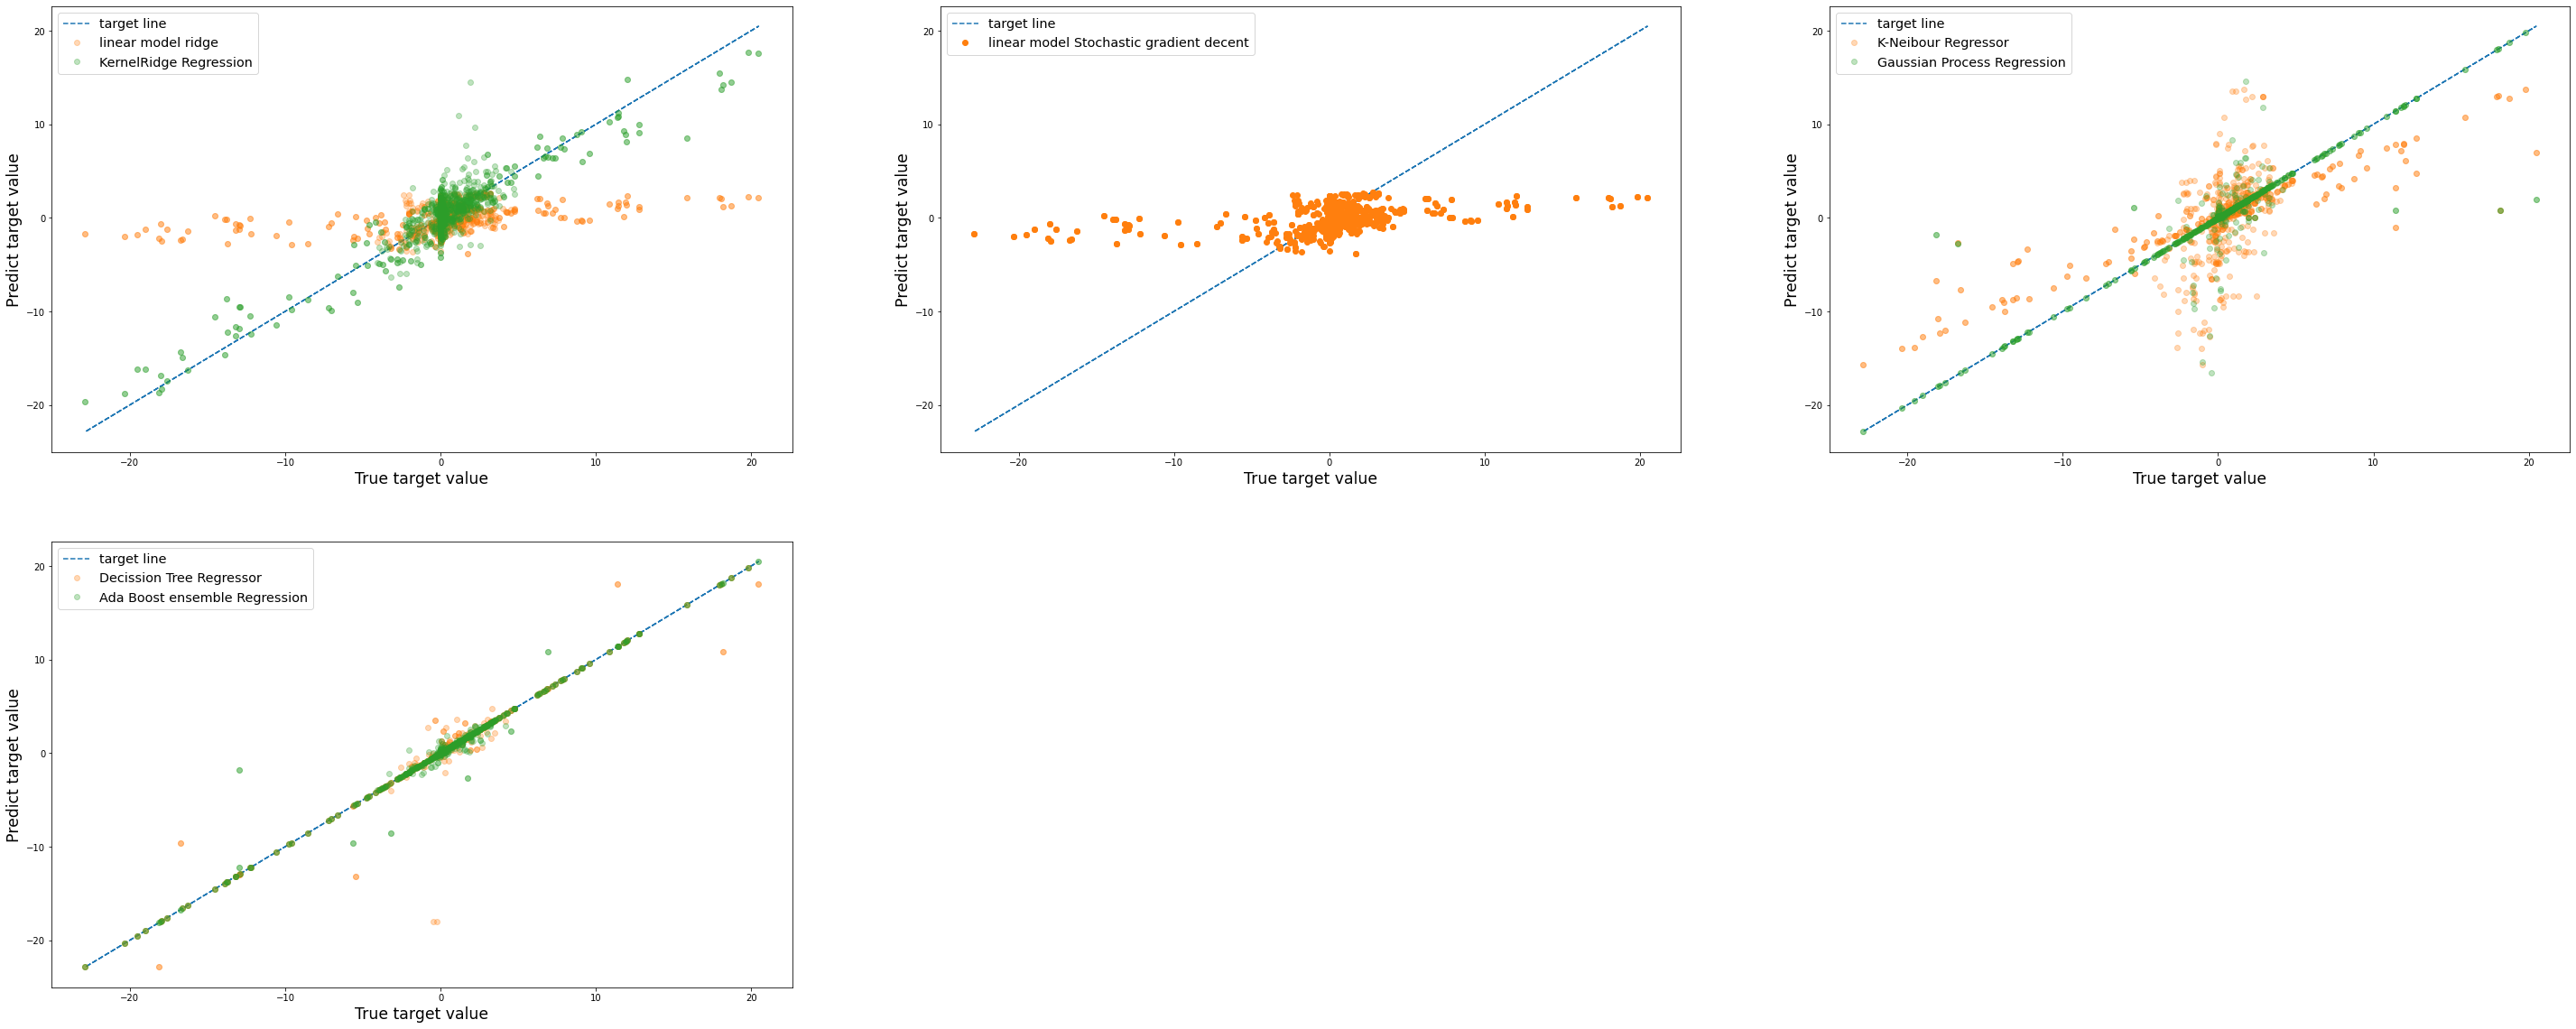

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,20))
#plt.subplots(2,2)

ll=plt.subplot(2,3,1)
pre_y_ridge = rid_reg.predict(X)
pre_y_KerRid = KerRid_reg.predict(X)

ll.plot(y,y, ls='--', label='target line')
ll.plot(y, pre_y_ridge, 'o', alpha=0.3, label='linear model ridge')
ll.plot(y, pre_y_KerRid, 'o', alpha=0.3, label='KernelRidge Regression')
ll.set_xlabel('True target value', fontsize='xx-large')
ll.set_ylabel('Predict target value', fontsize='xx-large')
ll.legend(fontsize='x-large')

ll=plt.subplot(2,3,2)
pre_y_sgd = rid_reg.predict(X)
ll.plot(y,y, ls='--', label='target line')
ll.plot(y, pre_y_sgd, 'o', label='linear model Stochastic gradient decent')
ll.set_xlabel('True target value', fontsize='xx-large')
ll.set_ylabel('Predict target value', fontsize='xx-large')
ll.legend(fontsize='x-large')

ll=plt.subplot(2,3,3)
pre_y_KNei = KNeiReg.predict(X)
pre_y_Gau = GauProReg.predict(X)
ll.plot(y,y, ls='--', label='target line')
ll.plot(y, pre_y_KNei, 'o', alpha=0.3, label='K-Neibour Regressor')
ll.plot(y, pre_y_Gau, 'o', alpha=0.3, label='Gaussian Process Regression')
ll.set_xlabel('True target value', fontsize='xx-large')
ll.set_ylabel('Predict target value', fontsize='xx-large')
ll.legend(fontsize='x-large')

ll=plt.subplot(2,3,4)
pre_y_DecTree = DecTreReg.predict(X)
pre_y_AdaBoo = AdaBooReg.predict(X)
ll.plot(y,y, ls='--', label='target line')
ll.plot(y, pre_y_DecTree, 'o', alpha=0.3, label='Decission Tree Regressor')
ll.plot(y, pre_y_AdaBoo, 'o', alpha=0.3, label='Ada Boost ensemble Regression')
ll.set_xlabel('True target value', fontsize='xx-large')
ll.set_ylabel('Predict target value', fontsize='xx-large')
ll.legend(fontsize='x-large')



In [160]:
diffs_rel = []

for i in range(len(y)):
    inp = np.reshape(np.array(X.iloc[i]), newshape=(1,-1))
    Zi = inp[0][0]
    Zj = inp[0][1]
    diffs_rel.append([Zi, Zj, (AdaBooReg.predict(inp)[0] - y[i])])
diffs_rel = np.array(diffs_rel)


In [200]:
%timeit AdaBooReg.predict(inp)

10.8 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [201]:
%timeit DecTreReg.predict(inp)

69.2 µs ± 1.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [202]:
%timeit KerRid_reg.predict(inp)

473 µs ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


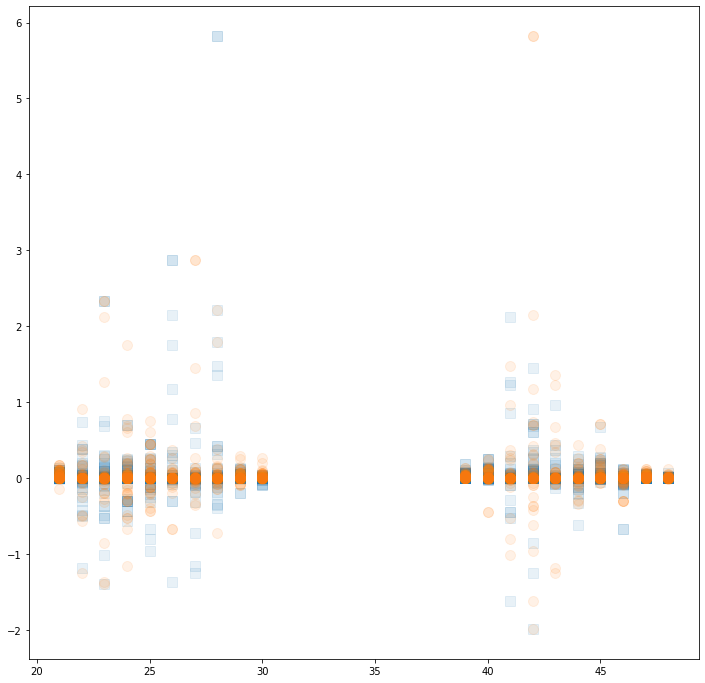

In [168]:
plt.figure(figsize=(12,12))
# plt.scatter(diffs_rel[:,0], diffs_rel[:,1], c=diffs_rel[:,2], lw=0, s=100)
# plt.colorbar()
plt.plot(diffs_rel[:,0], diffs_rel[:,2], 's', ms=10, alpha=0.1, )
plt.plot(diffs_rel[:,1], diffs_rel[:,2], 'o', ms=10, alpha=0.1, )
# plt.axhline(0.1);plt.axhline(-0.1)

0.8653846153846154

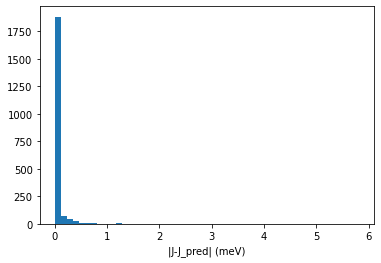

In [163]:
plt.hist(abs(diffs_rel[:,2]), bins=50, )#cumulative=True, density=True)
# plt.ylim(0.75)
plt.xlabel('|J-J_pred| (meV)')
# plt.ylabel('%')
1800/len(diffs_rel[:,2])

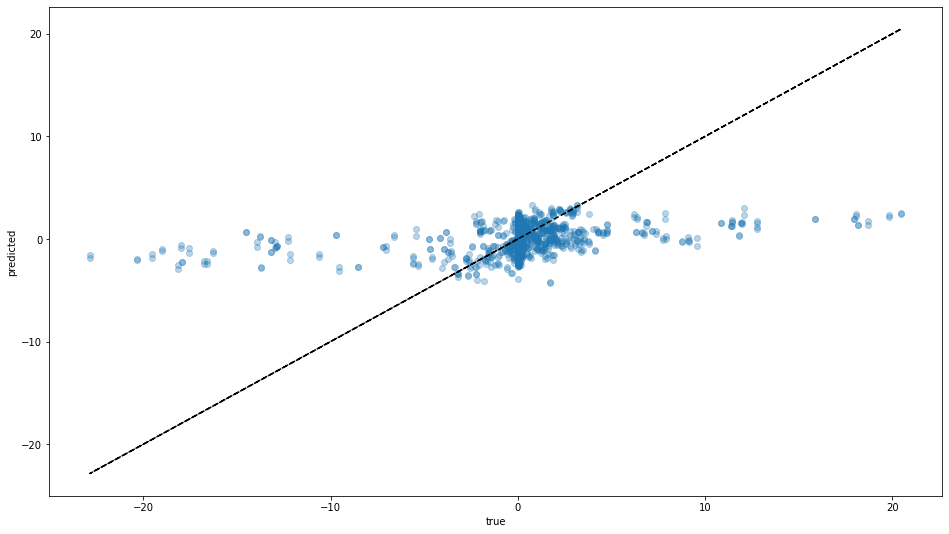

In [68]:
from figrecipes import PlotlyFig
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
cv_y_pred = cross_val_predict(lr, X, y, cv=crossvalidation)
lr_pred = lr.predict(X)

plt.figure(figsize=(16,9))
plt.plot(y, cv_y_pred, 'o', alpha=0.3)
plt.plot(y,y, color='k', ls='--')
plt.xlabel('true')
plt.ylabel('predicted')
plt.show()

In [90]:
X.columns

Index(['imp0', 'imp1', 'rx', 'ry', 'rz', 'r', 'mom1', 'mom2', 's00', 'd00',
       's01', 'd01', 'group1', 'period1', 'en1', 'group2', 'period2', 'en2',
       'del_imp', 'del_d', 'del_s', 'del_en', 'd00_odd_spin', 'd01_odd_spin',
       's00_odd_spin', 's01_odd_spin', 'tot_odd_spin_00', 'tot_odd01_spin_00'],
      dtype='object')

In [91]:
# Trying Random forest model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=1, oob_score=True)

rf.fit(X, y)
print('all R2 = ' + str(round(rf.score(X, y), 3)))
print('all RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(X))))

rf.fit(Xtrain, ytrain)
print('training R2 = ' + str(round(rf.score(Xtrain, ytrain), 3)))
print('test R2 = ' + str(round(rf.score(Xtest, ytest), 3)))

print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=ytrain, y_pred=rf.predict(Xtrain))))
print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=ytest,
                                                      
                                                      y_pred=rf.predict(Xtest))))

In [ ]:
rf.predict(np.reshape(np.array(Xtest.loc[100]), newshape=(1,-1))), ytest[100]

In [95]:
np.array(Xtrain.iloc[5]).reshape(1,-1)
ytest[101]

0.0397861754

In [96]:
cv_y_pred1 = cross_val_predict(rf, Xtrain, ytrain, cv=crossvalidation)
cv_y_pred2 = cross_val_predict(rf, Xtest, ytest, cv=crossvalidation)

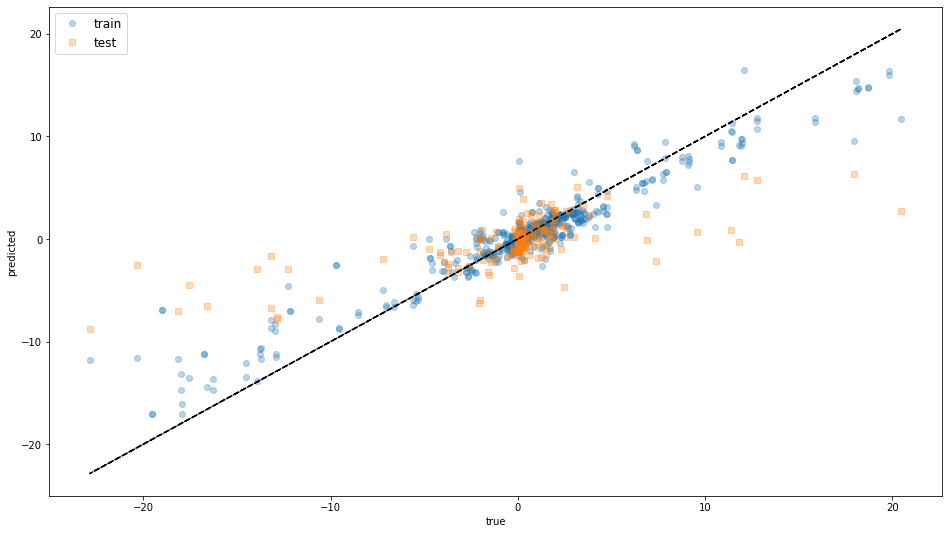

<Figure size 432x288 with 0 Axes>

In [97]:
plt.figure(figsize=(16,9))
# plt.plot(y, cv_y_pred, 'o', alpha=0.3)
plt.plot(ytrain, cv_y_pred1, 'o', alpha=0.3, label='train')
plt.plot(ytest, cv_y_pred2, 's', alpha=0.3, label='test')
plt.legend(fontsize='large')
plt.plot(y,y, color='k', ls='--')
plt.xlabel('true')
plt.ylabel('predicted')
plt.show()
plt.savefig('delete.pdf')

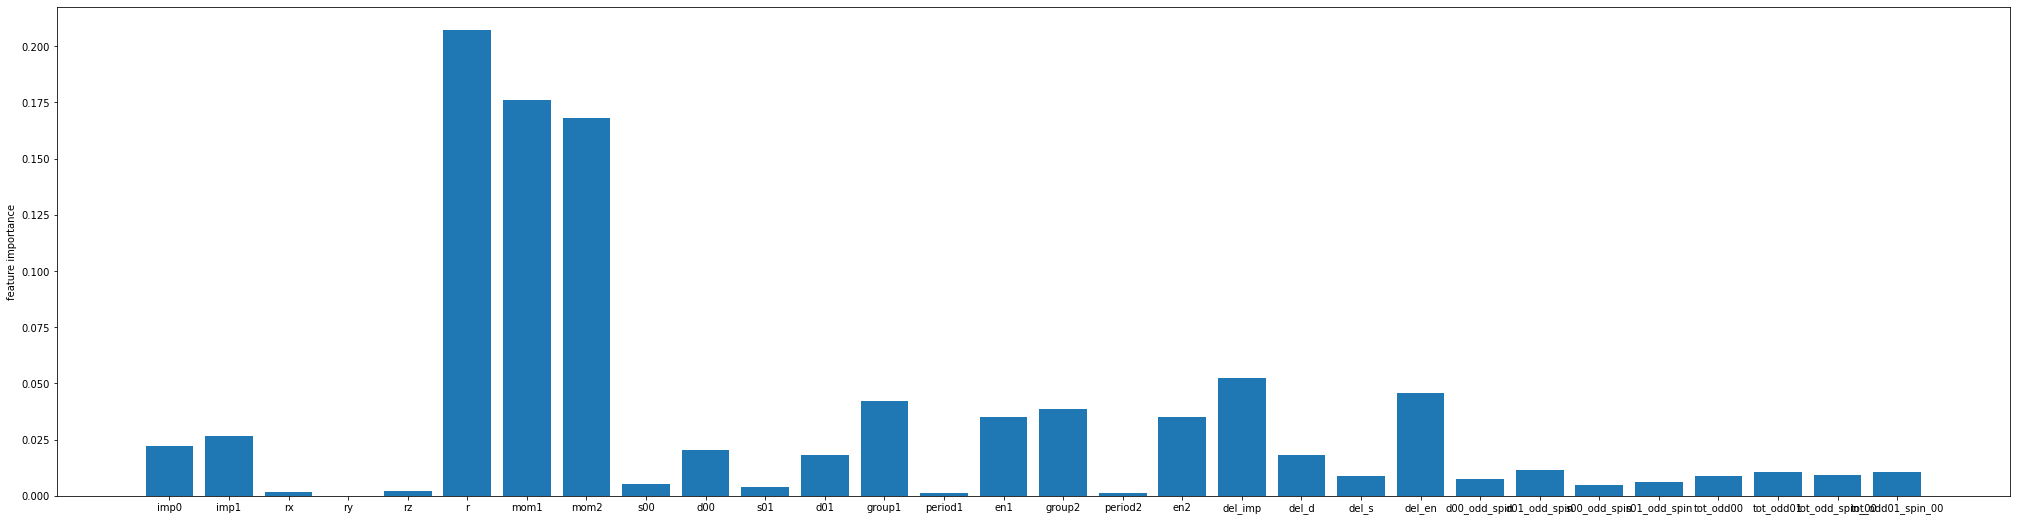

In [98]:
from matplotlib import pyplot as plt
plt.figure(figsize=(35,9))
plt.bar(range(len(X.columns)), rf.feature_importances_)
plt.xticks(range(len(X.columns)), X.columns)
plt.ylabel('feature importance')
plt.show()

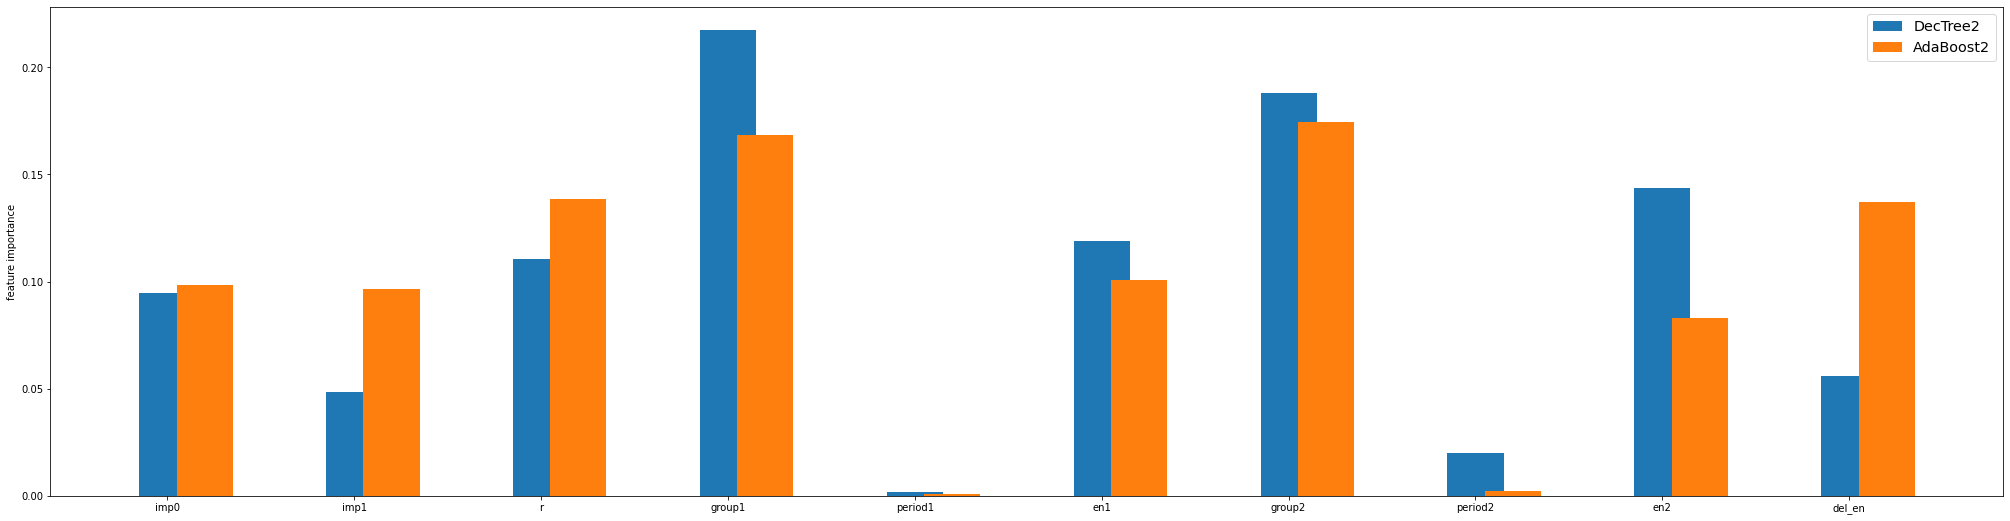

In [114]:
from matplotlib import pyplot as plt
plt.figure(figsize=(35,9))
# plt.bar(np.arange(len(X.columns))-0.2, DecTreReg.feature_importances_, width=0.3, label='DecTree')
plt.bar(np.arange(len(X2.columns))-0.00, DecTreReg2.feature_importances_, width=0.3, label='DecTree2')
plt.bar(np.arange(len(X2.columns))+0.2, AdaBooReg2.feature_importances_, width=0.3, label='AdaBoost2')
# plt.bar(np.arange(len(X.columns))+0.15, KerRid_reg.feature_importances_, width=0.3, label='KRR')
plt.legend(fontsize='x-large')
plt.xticks(range(len(X2.columns)), X2.columns)
plt.ylabel('feature importance')
plt.show()

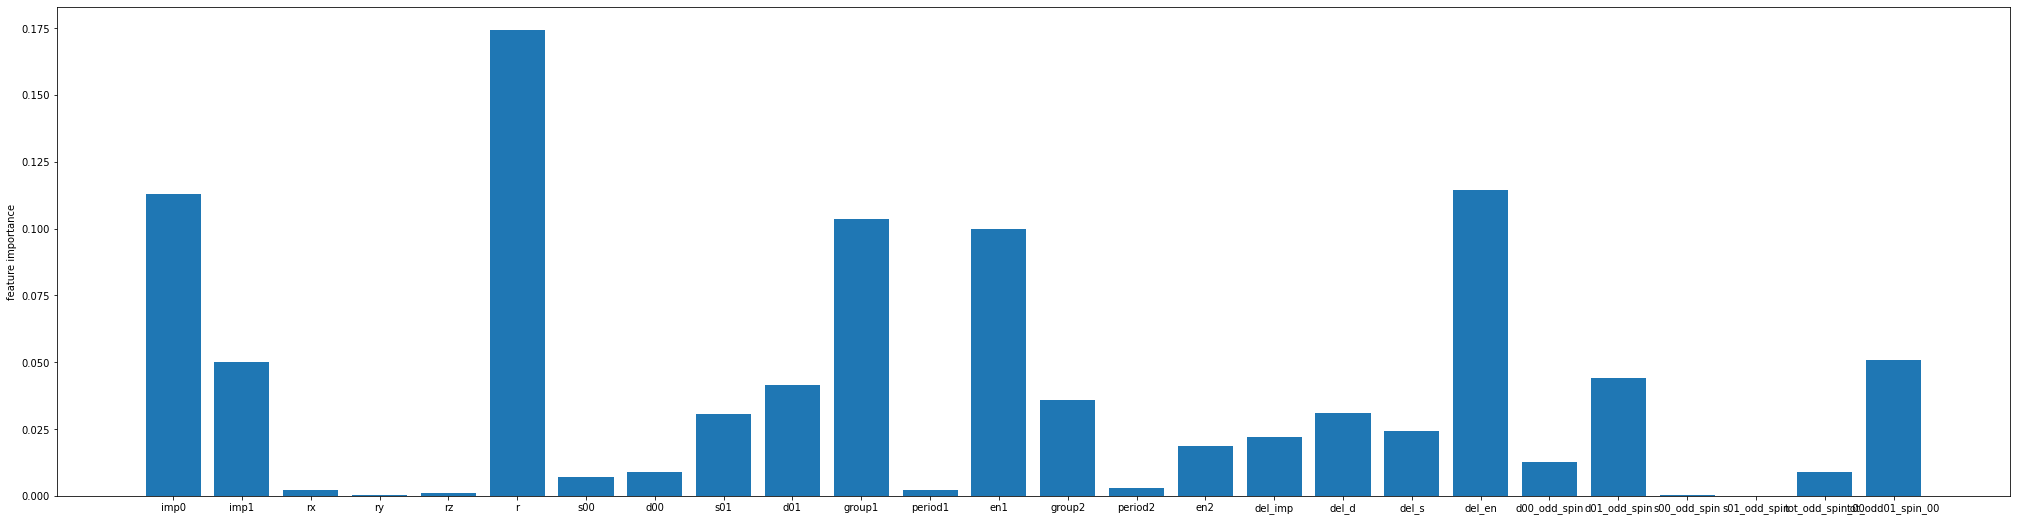

In [89]:
from matplotlib import pyplot as plt
plt.figure(figsize=(35,9))
plt.bar(range(len(X.columns)), DecTreReg.feature_importances_)
plt.xticks(range(len(X.columns)), X.columns)
plt.ylabel('feature importance')
plt.show()

In [31]:
rf.feature_importances_.sum()

1.0

In [93]:
#AdaBoostRegressor?


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m

font = {'family':'normal',
        'weight': 'bold',
        'size':13}
m.rc('font',**font)
colors = ['b', 'g', 'r', 'c', 'm', 'y']

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


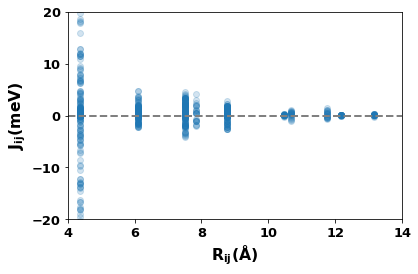

In [95]:
jij = list(df_ml_ext['J'])
dis = np.array(list(df_ml_ext['r']))* 10.472657559692419
plt.scatter(dis, jij, alpha=0.2)
plt.xlabel('$\mathrm{R_{ij} (\AA)}$', fontsize='large')
plt.ylabel('$\mathrm{J_{ij} (meV)}$', fontsize = 'large')
plt.axhline(0, ls='--', color='grey', linewidth=2)
plt.ylim(-20,20)
plt.xlim(4,14)
plt.tight_layout()
plt.savefig('Jij_vs_R_all_DFT.png', dpi=300)